<a href="https://colab.research.google.com/github/bmijangos/ProyectoIntegrador/blob/main/Avance3_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 3
## Baseline
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
19 de mayo de 2024

# Importaciones, Funciones, Dependencias y Pasos Iniciales

In [1]:
!pip install --upgrade nbformat nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


In [2]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score  # Importar accuracy_score desde sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Las siguientes librerías son los modelos que voy a entrenar y el método de validación cruzada k-fold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree  # para el grafico de arbol de decision
from IPython.display import Image

import scipy.cluster.hierarchy as sch   # requerimos el módulo referente a la agrupamiento jerárquico.
from sklearn.cluster import AgglomerativeClustering    # usaremos la técnica de agrupamiento llamada aglomerativa


In [4]:
# función para mostrar un diagrama de caja encima de un histograma
def plot_boxplot_hist(data, variable):
  f,(ax_box, ax_hist) = plt.subplots(2,
                                     sharex=True,
                                     gridspec_kw={"height_ratios":(0.50,0.85)})
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data, x=variable, ax=ax_hist)
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()


In [5]:
# función para encontrar los límites de una distribución variable usando la regla de proximidad del rango intercuartil:

def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR * fold)
  upper_limit = df[variable].quantile(0.75)+(IQR * fold)
  return lower_limit, upper_limit

In [6]:
def get_models():

    models = list()
    names = list()

    # LR - Regresión Logística:
    models.append(LogisticRegression(solver='liblinear'))
    names.append('Logistic Regression')

    # DT - Árbol de Decisión:
    models.append(DecisionTreeClassifier())
    names.append('Decision Tree')

    # RFC - Random forest classifier
    models.append(RandomForestClassifier())
    names.append('Random Forest Classifier')

    return models, names

In [7]:
def mi_accuracy (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_accuracy = (VP + VN) / (VP + VN + FP + FN)
  return mi_accuracy

def mi_precision (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_precision = VP / (VP + FP)
  return mi_precision

def mi_recall (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_recall = VP / (VP + FN)
  return mi_recall

def mi_f1_score (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_f1_score = (2*VP) / (2*VP + FP + FN)
  return mi_f1_score

def mi_G_mean (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_G_mean = np.sqrt((VP / (VP + FN))*(VN / (VN + FP)))
  return mi_G_mean

In [8]:
def plot_roc(fpr_svc, tpr_svc, roc_auc_svc):
  plt.figure()
  plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [9]:
def calculate_print_metrics(model, y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, pos_label='CAN')
  recall = recall_score(y_test, y_pred, pos_label='CAN')
  f1 = f1_score(y_test, y_pred, pos_label='CAN')
  confusion_matrixs = confusion_matrix(y_test, y_pred)

  print(model)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("Confusion Matrix:\n", confusion_matrixs)

# Lectura de los datos

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [10]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

In [11]:
grupal_df.isnull().sum()

IdCliente                   0
FechaAltaCliente            0
CodigoGrupo                 0
EdadCliente                 0
Genero                      0
EstadoCivil                 0
Escolaridad              1243
CapacidadPago               0
Localidad                   0
CodigoSucursal              0
CodigoASesor                0
NumeroCredito               0
CicloCliente                0
FechaDesembolso             0
FechaVencimiento            0
FechaCancelacion            0
Plazo                       0
PeriodoPago                 0
EstatusCredito              0
MontoCredito                0
CuotaNumero                 0
CuotaFechaVencimiento       0
CuotaFechaCancelacion     128
MontoCuota                  0
MontoCapital                0
SaldoCapital                0
EstatusCuota                0
DiasAtraso                128
dtype: int64

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

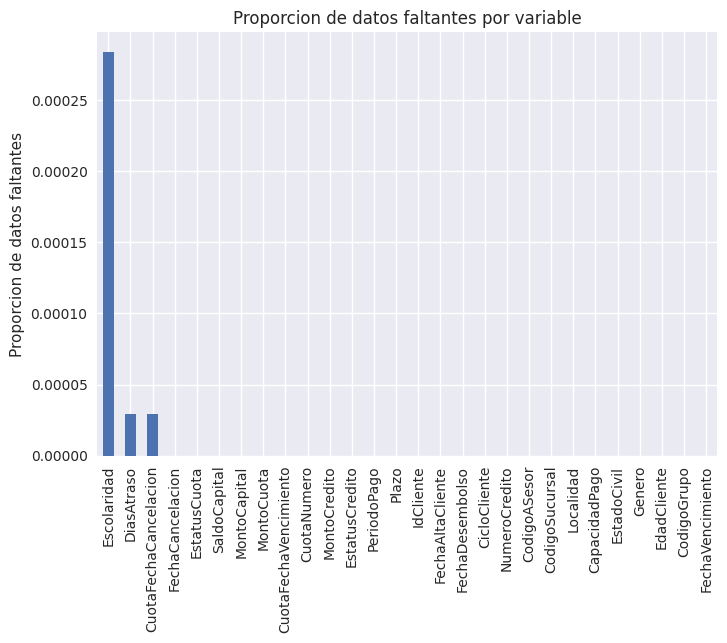

In [11]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [12]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [13]:
gpdf.isnull().values.any()

False

In [14]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

In [15]:
gpdf.shape

(4380844, 28)

In [14]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [15]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [ ]:
print(gpdf.describe(include=[object]))

               FechaAltaCliente   Genero Escolaridad CodigoASesor  \
count                   4380844  4380844     4380844      4380844   
unique                    15962        2          14          528   
top     2004-02-05 00:00:00.000        F          1A       ACORZO   
freq                       7669  4378507     1302653        98613   

                FechaDesembolso         FechaVencimiento  \
count                   4380844                  4380844   
unique                     3268                     2816   
top     2013-04-30 00:00:00.000  2019-06-04 00:00:00.000   
freq                       6944                     4869   

               FechaCancelacion   PeriodoPago EstatusCredito  \
count                   4380844       4380844        4380844   
unique                     3303             3              2   
top     2015-12-08 00:00:00.000  CATORCENA(S)            CAN   
freq                       7115       3816897        4253254   

          CuotaFechaVencimiento 

In [ ]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Se agregan los valores Maximos, la Media y la Mediana de la variable DiasAtraso por cliente y por credito

In [16]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
gpmdadf = gpdf.groupby(['IdCliente','EdadCliente','NumeroCredito','CicloCliente','Plazo','EstadoCivil','EstatusCredito'])['DiasAtraso'].max().reset_index()

# renombramos la columna de la media
gpmdadf.rename(columns={'DiasAtraso':'DAMax'}, inplace=True)

gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 23.2+ MB


In [17]:
# obtenemos media de los Dias de Atraso por credito
gpmeandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].mean().reset_index()

# obtenemos mediana de los Dias de Atraso por credito
gpmediandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].median().reset_index()

# renombramos la columna de la media
gpmeandf.rename(columns={'DiasAtraso':'DAMean'}, inplace=True)

# renombramos la columna de la mediana
gpmediandf.rename(columns={'DiasAtraso':'DAMedian'}, inplace=True)


In [20]:
gpmeandf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMean         380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [21]:
gpmediandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMedian       380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [ ]:
print(gpmdadf[gpmdadf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax  
1            CAN    0.0  
2            CAN    2.0  
3            CAN    2.0  
4            CAN  185.0  


In [ ]:
print(gpmeandf[gpmeandf['IdCliente']==6])

   IdCliente  NumeroCredito     DAMean
1          6     1000539201   0.000000
2          6     1000619301   0.333333
3          6     1000696601   0.466667
4          6     1000835501  23.400000


In [ ]:
print(gpmediandf[gpmediandf['IdCliente']==6])

   IdCliente  NumeroCredito  DAMedian
1          6     1000539201       0.0
2          6     1000619301       0.0
3          6     1000696601       0.0
4          6     1000835501       1.0


In [18]:
# agregamos la columan de la media
newdf = pd.merge(gpmdadf, gpmeandf[['IdCliente','NumeroCredito','DAMean']], on=['IdCliente','NumeroCredito'], how='left')

# agregamos la columna de la mediana
newdf = pd.merge(newdf, gpmediandf[['IdCliente','NumeroCredito','DAMedian']], on=['IdCliente','NumeroCredito'], how='left')

In [19]:
# mostramos los datos del cliente 6
print(newdf[newdf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax     DAMean  DAMedian  
1            CAN    0.0   0.000000       0.0  
2            CAN    2.0   0.333333       0.0  
3            CAN    2.0   0.466667       0.0  
4            CAN  185.0  23.400000       1.0  


In [20]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
 8   DAMean          380284 non-null  float64
 9   DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 29.0+ MB


In [21]:
newdf.head()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,EstatusCredito,DAMax,DAMean,DAMedian
0,4,65,1000353601,1,15,4,CAN,2.0,0.266667,0.0
1,6,34,1000539201,1,15,5,CAN,0.0,0.000000,0.0
2,6,34,1000619301,2,15,5,CAN,2.0,0.333333,0.0
3,6,35,1000696601,3,15,5,CAN,2.0,0.466667,0.0
4,6,36,1000835501,4,25,5,CAN,185.0,23.400000,1.0


# Algoritmo

Nosotros elegimos los algoritmos SVM (Support Vector Machine) y RFC (Random Forest Classifier) para desarrollar modelos de clasificación destinados a evaluar el riesgo crediticio de los clientes. En este contexto, el objetivo es predecir si un cliente realizará o no el pago de su crédito, lo cual es fundamental para mitigar los riesgos financieros asociados.

El algoritmo SVM es una opción adecuada para este problema debido a su capacidad para manejar conjuntos de datos complejos y separables no linealmente. Buscamos encontrar separar de manera óptima las instancias de clientes que pagan (CAN) de aquellos que no pagan (CAI), maximizando el margen entre las clases y minimizando el error de clasificación.

Por otro lado, el algoritmo RFC se ha utilizado debido a su capacidad para manejar características no lineales y manejar eficientemente problemas de clasificación con grandes conjuntos de datos. Usar RFC permite capturar relaciones complejas entre las características y las clases objetivo, mejorando así la capacidad del modelo para predecir con precisión si un cliente pagará o no su crédito.

Además, he aplicado el algoritmo K-Means para segmentar a los clientes en tres grupos distintos con el fin de ajustar el sentimiento en mi chatbot. Esta segmentación proporciona una comprensión más profunda de las preferencias y comportamientos de los clientes, lo que permite adaptar la interacción del chatbot de manera más efectiva. *italicized text*

In [ ]:
missing_data = newdf.isnull().any()
print(missing_data)
#como no existen datos faltantes NO se imputan variables de entrada

IdCliente         False
EdadCliente       False
NumeroCredito     False
CicloCliente      False
Plazo             False
EstadoCivil       False
EstatusCredito    False
DAMax             False
DAMean            False
DAMedian          False
dtype: bool


Al no existir datos faltantes, NO se imputan variables de entrada.
Pero se imputaron en la creación del pipeline para dos tipos de variables, la categórica  y la binaria.

In [ ]:

#newgpdf = gpdf[features]
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
 8   DAMean          380284 non-null  float64
 9   DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 29.0+ MB


In [22]:
# Definir la variable objetivo y las características
X = newdf.drop('EstatusCredito', axis=1)  # Todas las columnas excepto 'EstatusCredito' son características independientes
y = newdf['EstatusCredito']  # 'EstatusCredito' es la variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones del conjunto de entrenamiento (X):", X_train.shape)
print("Dimensiones del conjunto de prueba (X):", X_test.shape)
print("Dimensiones del conjunto de entrenamiento (y):", y_train.shape)
print("Dimensiones del conjunto de prueba (y):", y_test.shape)


Dimensiones del conjunto de entrenamiento (X): (304227, 9)
Dimensiones del conjunto de prueba (X): (76057, 9)
Dimensiones del conjunto de entrenamiento (y): (304227,)
Dimensiones del conjunto de prueba (y): (76057,)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans

Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classifier
Accuracy: 0.9981987193815165
Classification Report:
               precision    recall  f1-score   support

         CAI       0.98      0.97      0.97      2462
         CAN       1.00      1.00      1.00     73595

    accuracy                           1.00     76057
   macro avg       0.99      0.98      0.99     76057
weighted avg       1.00      1.00      1.00     76057



SVM

In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)

# Entrenar el modelo
svm_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
print("Support Vector Machine Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Support Vector Machine Classifier
Accuracy: 0.9676295410021432


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

         CAI       0.00      0.00      0.00      2462
         CAN       0.97      1.00      0.98     73595

    accuracy                           0.97     76057
   macro avg       0.48      0.50      0.49     76057
weighted avg       0.94      0.97      0.95     76057



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Adicional a los los modelos anteriores se decide utilizar los algoritmos de Regresión Logística, Árbol de Decisión y KNN - K-Nearest Neighbors para desarrollar modelos de clasificación destinados a evaluar el riesgo crediticio de los clientes. En este contexto, el objetivo es predecir si un cliente realizará o no el pago de su crédito, lo cual es fundamental para mitigar los riesgos financieros asociados.

Dado que la Regresión Logística es fácil de implementar, rápida de entrenar y puede proporcionar resultados razonables, es una opción sólida como baseline para comenzar a abordar un problema de clasificación con un conjunto de datos de tamaño moderado como el que tenemos. Este es solo un ejemplo básico para ilustrar cómo puedes usar Regresión Logística como baseline para un problema de clasificación con los datos proporcionados.

Los árboles de decisión son modelos simples de entender e interpretar, lo que los hace útiles como baselines. Al igual que con la Regresión Logística, este es solo un ejemplo básico para ilustrar cómo se puede usar un Árbol de Decisión como baseline para un problema de clasificación.

Otro modelo de clasificación que puedes considerar como baseline es el clasificador de Vecinos más Cercanos (KNN - K-Nearest Neighbors).

Este ejemplo ilustra cómo puedes usar el clasificador KNN como baseline para un problema de clasificación con los datos proporcionados.

Para utilizar estos datos en un problema de clasificación, primero necesitamos definir cuál será nuestra variable objetivo, nuestro caso queremos predecir si un cliente pagará puntualmente su crédito o no, utilizamos la columna "EstatusCredito" como nuestra variable objetivo, donde "CAN" indica que el cliente pagó puntualmente y "CAI" indica que el cliente no pagó puntualmente.


Logistic Regression: 0.9676295410021432
Decision Tree: 0.9966998435383988
KNN: 0.9707456249917825


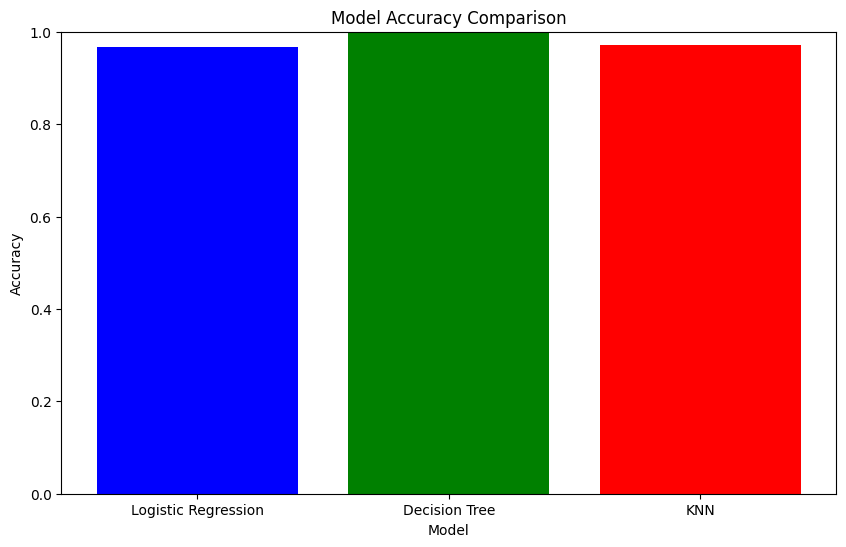

In [23]:

# Convertir las etiquetas de clase a valores binarios
newdf['Pagado'] = newdf['EstatusCredito'].map({'CAI': 0, 'CAN': 1})

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(newdf.drop(['EstatusCredito', 'Pagado'], axis=1), newdf['Pagado'], test_size=0.2, random_state=42)

# Inicializar y entrenar los modelos (Regresión Logística, Árbol de Decisión, KNN, Random Forest y SVM)
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'KNN': KNeighborsClassifier()}

# Entrenar los modelos y calcular la precisión en el conjunto de prueba
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy

# Imprimir las precisión de los modelos
for name, accuracy in accuracies.items():
    print(f'{name}: {accuracy}')

# Visualizar la precisión de los modelos en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Asegurar que el eje y vaya de 0 a 1 (precisión máxima)
plt.show()

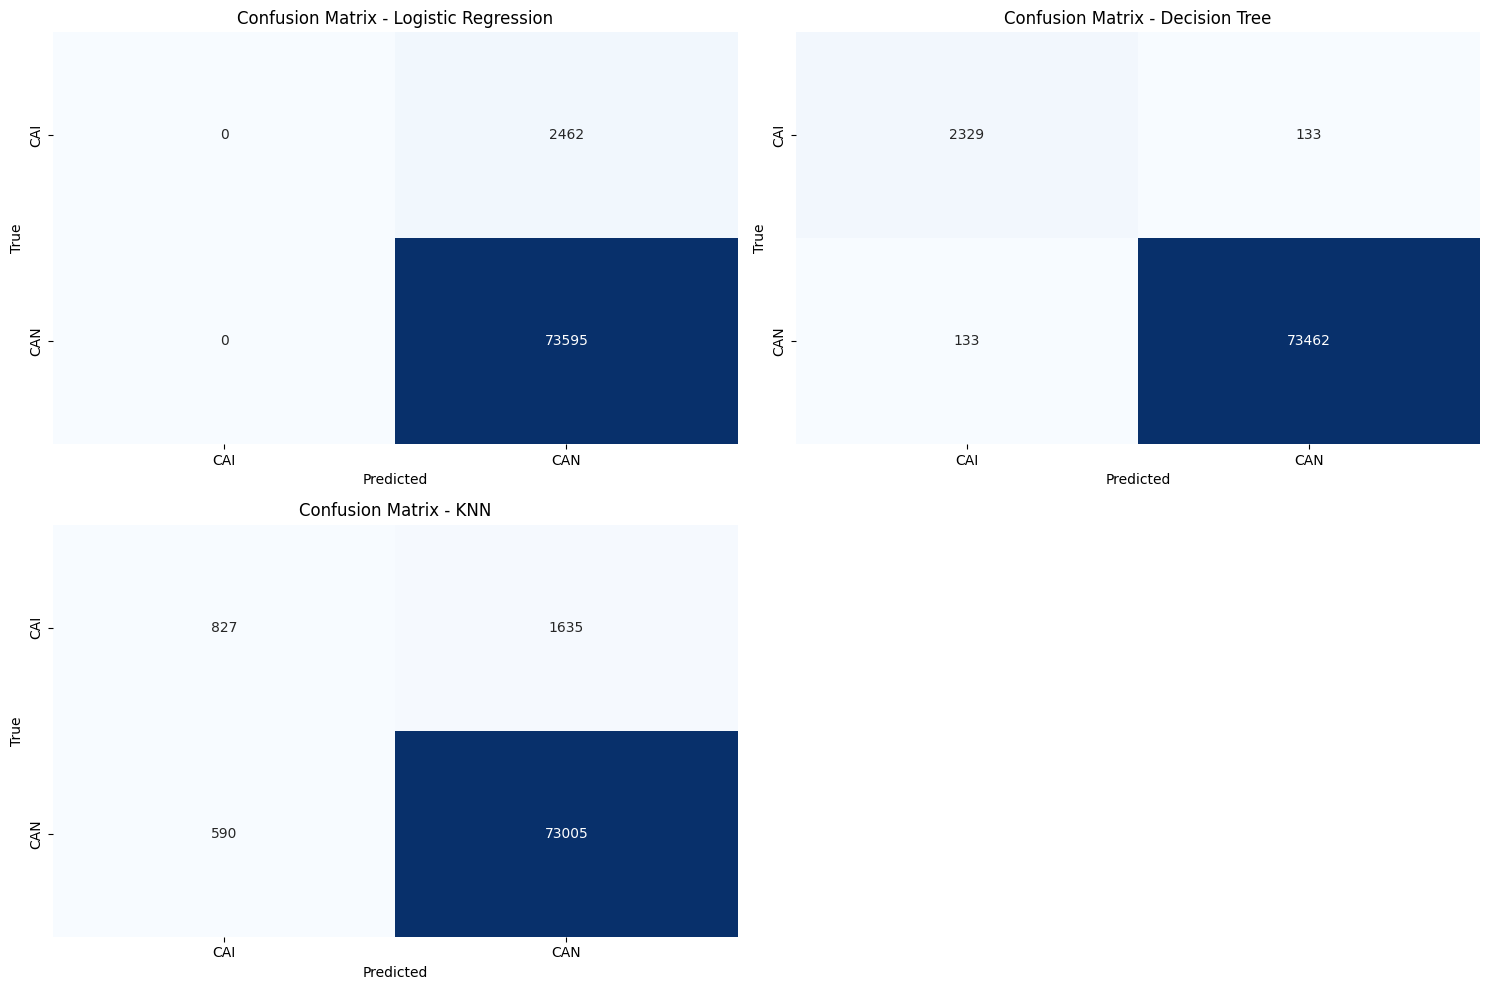

In [24]:
# Inicializar y entrenar los modelos (Regresión Logística, Árbol de Decisión y KNN)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred_logreg = logreg.predict(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_knn = knn.predict(X_test)

# Calcular y visualizar la matriz de confusión para cada modelo
models = [logreg, tree, knn]
model_names = ['Logistic Regression', 'Decision Tree', 'KNN']

plt.figure(figsize=(15, 10))
for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['CAI', 'CAN'], yticklabels=['CAI', 'CAN'])
    plt.title(f'Confusion Matrix - {model_names[i-1]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

K-means

El algoritmo K-Means no es un algoritmo de clasificación, sino un algoritmo de agrupamiento (o clustering). Su objetivo principal es dividir un conjunto de datos en un número predeterminado de grupos (o clusters) basados en las características de los datos.

A diferencia de los algoritmos de clasificación, donde se tienen etiquetas de clase para los datos de entrenamiento y el objetivo es predecir la clase de nuevos datos, en el clustering no hay etiquetas de clase. En su lugar, el algoritmo busca agrupar los datos en grupos basados en la similitud de sus características.

En este ejemplo, estamos utilizando el algoritmo K-Means para agrupar los datos en 3 clusters basados en las características proporcionadas. Los centros de los clusters se muestran al final del código. tomando en cuenta que, dado que el K-Means es un algoritmo de clustering, no hay etiquetas de clase como en el caso de los algoritmos de clasificación. Los datos se agrupan en clusters, pero no se asignan a clases específicas.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


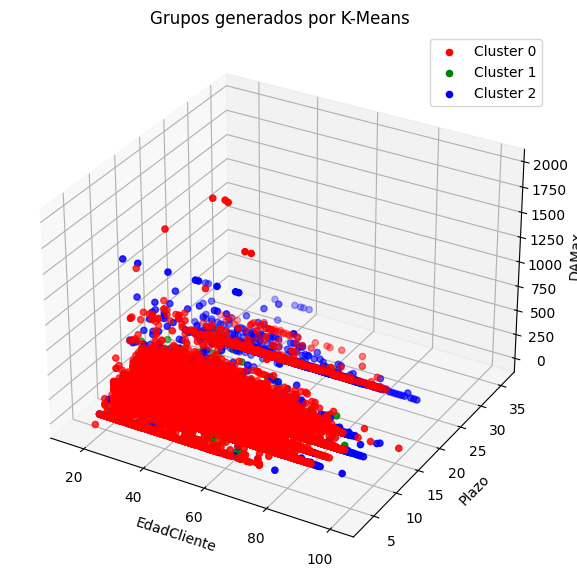

In [26]:
from sklearn.cluster import KMeans

# Inicializar el modelo K-Means
kmeans = KMeans(n_clusters=3, random_state=42)

# Ajustar el modelo a los datos
kmeans.fit(X)

# Obtener las etiquetas de los clusters asignados a cada punto de datos
labels = kmeans.labels_

# Añadir las etiquetas de los clusters al DataFrame
newdf['Cluster'] = labels

# Visualizar los grupos en un diagrama de dispersión 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i in range(3):
    cluster_data = newdf[newdf['Cluster'] == i]
    ax.scatter(cluster_data['EdadCliente'], cluster_data['Plazo'], cluster_data['DAMax'], c=colors[i], label=f'Cluster {i}')

ax.set_xlabel('EdadCliente')
ax.set_ylabel('Plazo')
ax.set_zlabel('DAMax')
plt.title('Grupos generados por K-Means')
plt.legend()
plt.show()

# Características importantes

*Importancia de las características*

Los siguientes códigos utiliza un modelo de Árbol de Decisión (DecisionTreeClassifier) para entrenar un modelo con datos de entrenamiento (X_train, y_train). Luego, utiliza el atributo feature_importances_ del modelo para obtener la importancia de cada característica. Esta importancia representa cuánto contribuye cada característica a la toma de decisiones del modelo.

El código proporciona la importancia de cada característica en el modelo de Árbol de Decisión. Luego, utiliza matplotlib para visualizar esta importancia en un gráfico de barras. Cada barra en el gráfico representa la importancia de una característica en la toma de decisiones del modelo.

In [31]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Dividir los datos en características (X) y etiquetas (y)
X = newdf.drop(['EstatusCredito'], axis=1)
y = newdf['EstatusCredito']

# Inicializar y entrenar el modelo de Árbol de Decisión
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X, y)

# Obtener la importancia de las características
importance = tree_classifier.feature_importances_

# Crear un DataFrame para mostrar la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Imprimir la importancia de las características
print(feature_importance_df)


          Feature  Importance
9          Pagado         1.0
0       IdCliente         0.0
1     EdadCliente         0.0
2   NumeroCredito         0.0
3    CicloCliente         0.0
4           Plazo         0.0
5     EstadoCivil         0.0
6           DAMax         0.0
7          DAMean         0.0
8        DAMedian         0.0
10        Cluster         0.0


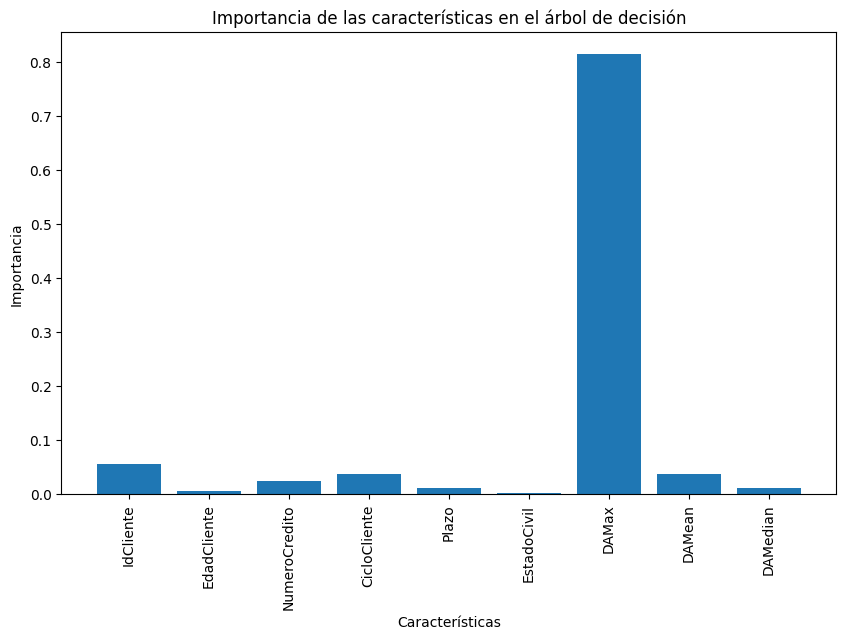

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


modelo = DecisionTreeClassifier()


modelo.fit(X_train, y_train)

# Obtener la importancia de las características
importancias_caracteristicas = modelo.feature_importances_

# Crear un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(range(len(importancias_caracteristicas)), importancias_caracteristicas)
plt.xticks(range(len(importancias_caracteristicas)), X.columns, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características en el árbol de decisión')
plt.show()


# Sub/Sobre ajuste

En esta sección, re-evaluamos los modelos mediante validación cruzada para identificar sesgos y sobreentrenamiento. Podemos concluir que nuestro modelo base necesita mejorar su capacidad de generalización, ya que con datos previamente vistos obtenía un accuraccy alto, pero con datos nuevos apenas llegaba a un accuracy de 0.6

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
rf_model_cv = RandomForestClassifier()

y_prob_rf_cv = cross_val_predict(rf_model_cv, X, y, cv=3, method='predict_proba')

# Realizar validación cruzada
rf_cv_scores = cross_val_score(rf_model_cv, X, y, cv=3)

# Mostrar los resultados de la validación cruzada
print("Random Forest Classifier - Cross-Validation Scores:", rf_cv_scores)
print("Mean CV Score:", rf_cv_scores.mean())

Random Forest Classifier - Cross-Validation Scores: [0.96767959 0.11964248 0.03267567]
Mean CV Score: 0.3733325768451692


In [ ]:
# La función cross_val_predict devuelve una matriz con dos columnas, una para cada clase.
# Seleccionamos las probabilidades de la clase positiva  'CAN'
y_prob_rf_cv_positive = y_prob_rf_cv[:, 1]

# Calcular las curvas ROC y AUC para cada pliegue
fpr_rf, tpr_rf, _ = roc_curve(y, y_prob_rf_cv_positive, pos_label='CAN')
roc_auc_rf = auc(fpr_rf, tpr_rf)


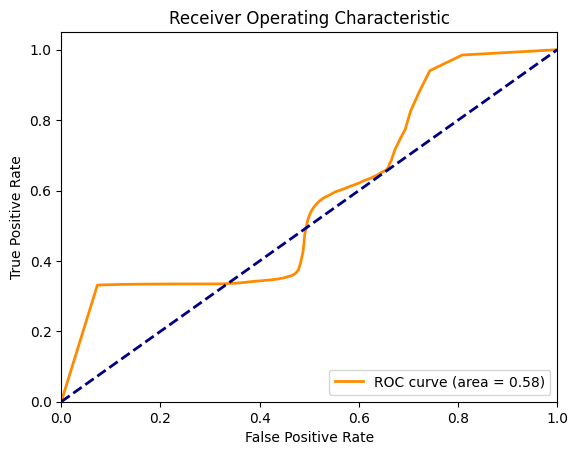

In [ ]:
plot_roc(fpr_rf, tpr_rf, roc_auc_rf)

El siguiente código calcula y visualiza la curva ROC para los modelos de Regresión Logística, Árbol de Decisión y KNN (Vecinos más Cercanos). Ajusta los nombres de las variables y el formato de los datos de acuerdo a tu conjunto de datos específico.

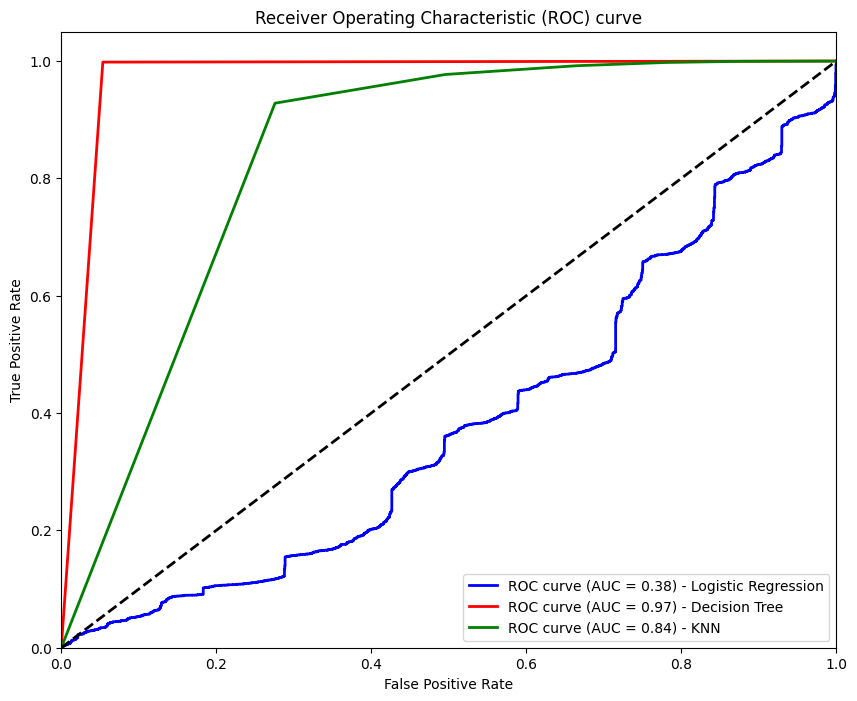

In [34]:
from sklearn.metrics import roc_curve, auc

# Convertir las etiquetas de clase a valores binarios
newdf['Pagado'] = newdf['EstatusCredito'].map({'CAI': 0, 'CAN': 1})

# Dividir los datos en conjunto de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(newdf.drop('EstatusCredito', axis=1), newdf['EstatusCredito'], test_size=0.2, random_state=42)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(newdf.drop(['EstatusCredito', 'Pagado'], axis=1), newdf['Pagado'], test_size=0.2, random_state=42)


# Inicializar y entrenar el modelo de Regresión Logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Inicializar y entrenar el modelo de Árbol de Decisión
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Inicializar y entrenar el modelo de KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Calcular las probabilidades de predicción para cada modelo
y_pred_logreg = logreg.predict_proba(X_test)[:, 1]
y_pred_tree = tree.predict_proba(X_test)[:, 1]
y_pred_knn = knn.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el área bajo la curva (AUC) para cada modelo
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Visualizar la curva ROC para cada modelo
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_logreg:.2f}) - Logistic Regression')
plt.plot(fpr_tree, tpr_tree, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_tree:.2f}) - Decision Tree')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_knn:.2f}) - KNN')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()

# Métricas

Las métricas de evaluación, como la precisión, el recall, el F1-Score y la matriz de confusión, son fundamentales en la evaluación de modelos de clasificación como el Support Vector Classifier (SVC) y el Random Forest Classifier (RFC) en el contexto del análisis de riesgo crediticio. Estas métricas proporcionan una comprensión detallada del rendimiento del modelo desde diferentes perspectivas. La precisión nos dice qué tan preciso es el modelo en general, mientras que el recall nos indica qué proporción de los casos positivos reales el modelo identifica correctamente. El F1-Score, por otro lado, ofrece una medida combinada que equilibra precisión y recall. Además, la matriz de confusión ofrece una visión detallada de los errores de clasificación del modelo, mostrando el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

In [ ]:
#Usando test_split
calculate_print_metrics("Random Forest", y_test, y_pred_rf)

Random Forest
Accuracy: 0.9981987193815165
Precision: 0.9989133092450216
Recall: 0.999225490862151
F1-Score: 0.9990693756665512
Confusion Matrix:
 [[ 2382    80]
 [   57 73538]]


In [ ]:
#Usando test_split
calculate_print_metrics("SVM", y_test, y_pred_svm)

SVM
Accuracy: 0.9676295410021432
Precision: 0.9676295410021432
Recall: 1.0
F1-Score: 0.9835484991847754
Confusion Matrix:
 [[    0  2462]
 [    0 73595]]


In [ ]:
#Usando test_split
calculate_print_metrics("SVM", y_test, y_pred_svm)

Como mencionamos, la alta precisión y recall, junto con una precisión global al total, sugieren un poosible sobreajuste del modelo. Estos resultados son sin antes haber utilizado cross validation, el cual haremos mas adelante.

Para este caso decidimos utilizar la metrica recall, ya que en el analisis de riesgo saber si un cliente paga es fundamental para el negocio. En este caso medimos a los clientes que efectivamente pagaron y fueron clasificados correctamente como "CAN" entre todos los casos que son realmente positivos



# Desempeño

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import numpy as np

# Definir la función para calcular el recall
def calcular_recall(modelo, X_train, y_train, X_val, y_val):
    modelo.fit(X_train, y_train)
    y_val_pred = modelo.predict(X_val)
    return recall_score(y_val, y_val_pred, average='weighted')

# Crear el validador cruzado estratificado
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar solo el clasificador SVM
modelo = SVC()

# Almacenar los recalls para cada fold
recalls = []

# Realizar la validación cruzada
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    recall = calcular_recall(modelo, X_train, y_train, X_val, y_val)
    recalls.append(recall)

# Imprimir los recalls
print("Recalls reducidos:")
print(recalls)
print("Recall promedio:", np.mean(recalls))

Recalls reducidos:
[0.9676163929684316, 0.9676163929684316, 0.9676163929684316, 0.96760324493472, 0.9676159671820763]
Recall promedio: 0.9676136782044182


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score

# Definir la función para calcular el recall
def calcular_recall(modelo, X_train, y_train, X_val, y_val):
    modelo.fit(X_train, y_train)
    y_val_pred = modelo.predict(X_val)
    return recall_score(y_val, y_val_pred, average='weighted')

# Crear el validador cruzado estratificado
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar solo el clasificador RFC
modelo = RandomForestClassifier()

# Almacenar los recalls para cada fold
recalls = []

# Realizar la validación cruzada
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    recall = calcular_recall(modelo, X_train, y_train, X_val, y_val)
    recalls.append(recall)

# Imprimir los recalls
print("Recalls reducidos:")
print(recalls)
print("Recall promedio:", np.mean(recalls))

Recalls reducidos:
[0.9980146469095547, 0.9979357587072853, 0.9976727980330542, 0.9980409429769778, 0.9982381403176607]
Recall promedio: 0.9979804573889066


# Conclusiones

